In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


Exploratory Data Analysis

In [30]:
subsmission_example = pd.read_csv("submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,35995.000000,35995.000000,35995.000000
mean,17998.000000,3683.508737,243.560217
std,10391.005806,18986.978708,1832.966999
min,1.000000,0.000000,0.000000
25%,8999.500000,0.000000,0.000000
50%,17998.000000,19.000000,0.000000
75%,26996.500000,543.000000,7.000000
max,35995.000000,345813.000000,33998.000000


Number of Country_Region:  184
Dates go from day 2020-05-15 to day 2020-01-22 , a total of 115 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


Text(0.5, 0, 'Date')

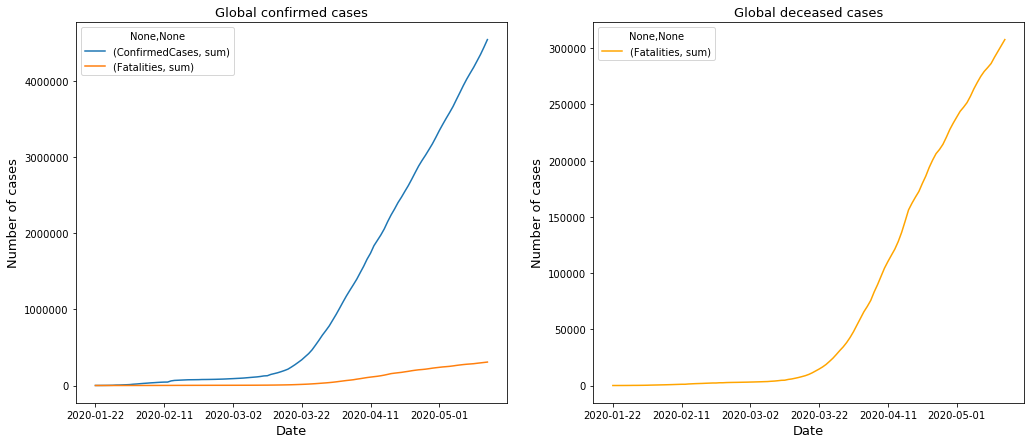

In [31]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

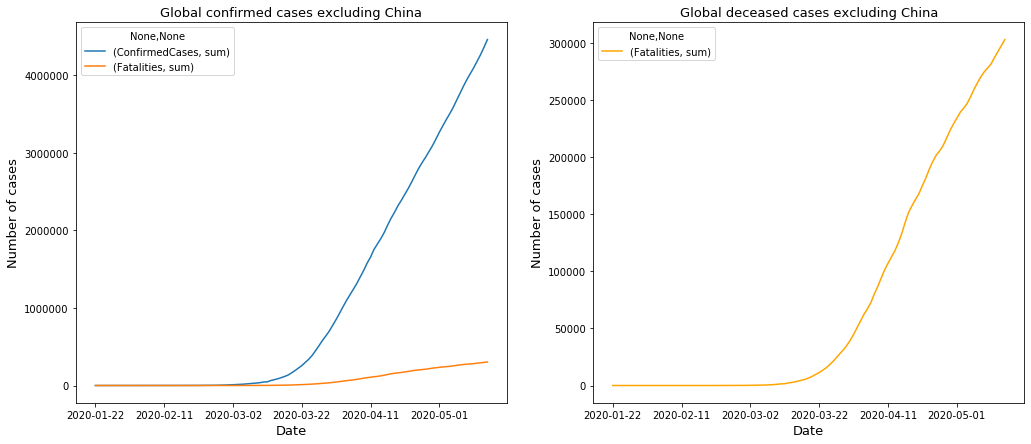

In [32]:
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

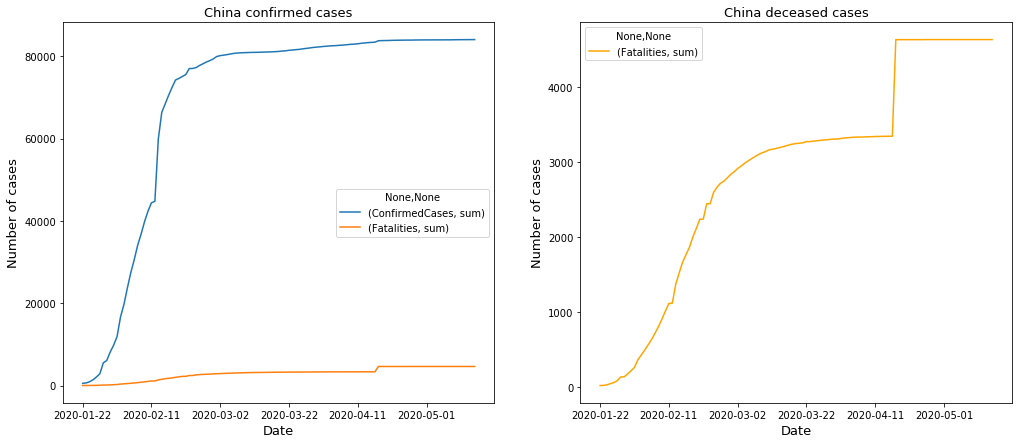

In [33]:
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [34]:
confirmed_total_date

,ConfirmedCases
,sum
Date,
2020-01-22,554.0
2020-01-23,653.0
2020-01-24,939.0
2020-01-25,1432.0
2020-01-26,2113.0
...,...
2020-05-11,4176589.0
2020-05-12,4260955.0


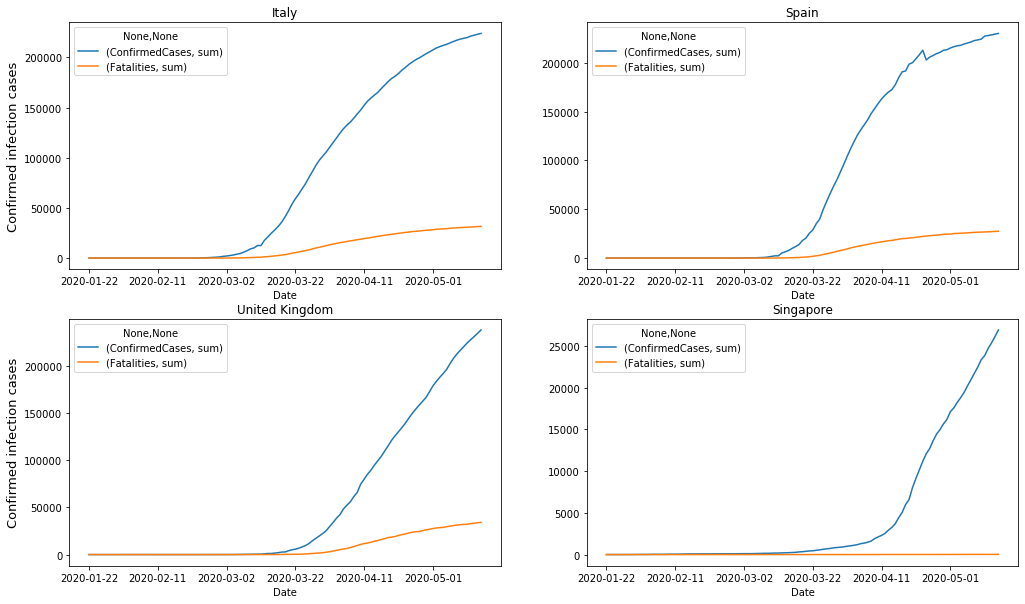

In [35]:
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

(0, 0.05)

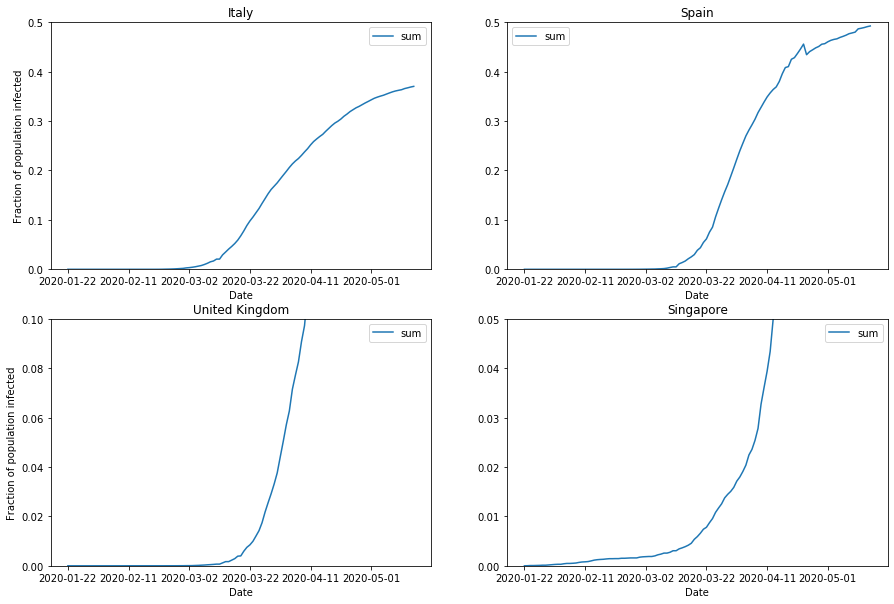

In [36]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.5)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.5)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.1)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.05)

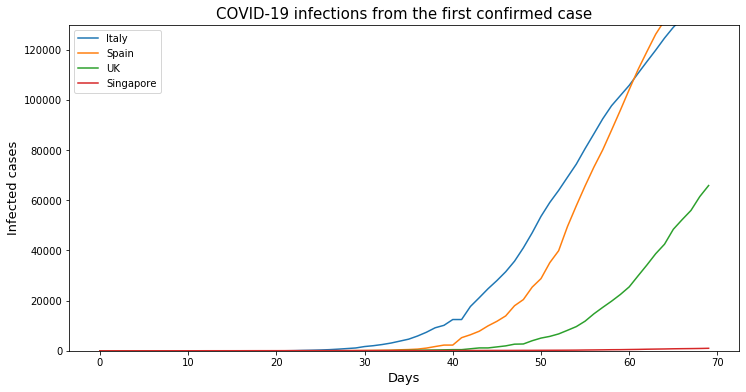

In [37]:
#confirmed_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:70] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:70] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:70] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:70] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 130000)
plt.show()

In [38]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [39]:
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [40]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

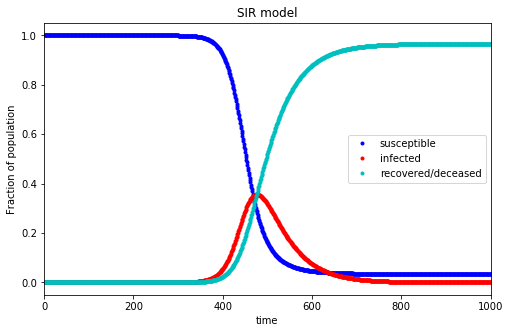

In [41]:
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

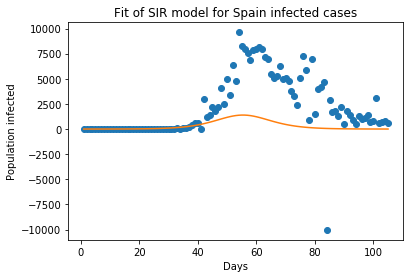

Optimal parameters: beta = 20.57444327524175  and gamma =  20.41594029511819


In [42]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [43]:
dates_overlap = ['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
                 '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-04-01', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-04-01', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

linear_model.LinearRegression()

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-04-01'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,5,2020
13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,5,2020
13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,5,2020
13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,5,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year


In [44]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [45]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  2.6068289279937744


In [18]:
all_data

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45067,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45068,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45069,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45070,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
22462,25571.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
22463,25572.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
22464,25573.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
22465,25574.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
22466,25575.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
22467,25576.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
22468,25577.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
22469,25578.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
22470,25579.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
22471,25580.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


In [20]:
# Load countries data file
world_population = pd.read_csv("population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1438207241,153,9388211,38,61
1,India,1377233523,464,2973190,28,35
2,US,330610570,36,9147420,38,83
3,Indonesia,272931713,151,1811570,30,56
4,Pakistan,219992900,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4991,50,100,19,10
231,Falkland Islands,3458,0,12170,19,66
232,Niue,1624,6,260,19,46
233,Tokelau,1354,136,10,19,0


Joined dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,Afghanistan,38742911.0,60.0,652860.0,18.0,25.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,Afghanistan,38742911.0,60.0,652860.0,18.0,25.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,Afghanistan,38742911.0,60.0,652860.0,18.0,25.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,Afghanistan,38742911.0,60.0,652860.0,18.0,25.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,Afghanistan,38742911.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45067,13454,-1.0,None,Zimbabwe,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,Zimbabwe,14818157.0,38.0,386850.0,19.0,38.0
45068,13455,-1.0,None,Zimbabwe,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,Zimbabwe,14818157.0,38.0,386850.0,19.0,38.0
45069,13456,-1.0,None,Zimbabwe,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,Zimbabwe,14818157.0,38.0,386850.0,19.0,38.0
45070,13457,-1.0,None,Zimbabwe,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,Zimbabwe,14818157.0,38.0,386850.0,19.0,38.0


Encoded dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,83,0,2020-01-22,0.0,0.0,-1.0,0,22,...,0.0,0.0,0.0,0.0,0.0,38742911.0,60.0,652860.0,18.0,25.0
1,1,2.0,83,0,2020-01-23,0.0,0.0,-1.0,1,23,...,0.0,0.0,0.0,0.0,0.0,38742911.0,60.0,652860.0,18.0,25.0
2,2,3.0,83,0,2020-01-24,0.0,0.0,-1.0,2,24,...,0.0,0.0,0.0,0.0,0.0,38742911.0,60.0,652860.0,18.0,25.0
3,3,4.0,83,0,2020-01-25,0.0,0.0,-1.0,3,25,...,0.0,0.0,0.0,0.0,0.0,38742911.0,60.0,652860.0,18.0,25.0
4,4,5.0,83,0,2020-01-26,0.0,0.0,-1.0,4,26,...,0.0,0.0,0.0,0.0,0.0,38742911.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45067,13454,-1.0,83,183,2020-05-10,0.0,0.0,13455.0,108,10,...,0.0,0.0,0.0,0.0,0.0,14818157.0,38.0,386850.0,19.0,38.0
45068,13455,-1.0,83,183,2020-05-11,0.0,0.0,13456.0,109,11,...,0.0,0.0,0.0,0.0,0.0,14818157.0,38.0,386850.0,19.0,38.0
45069,13456,-1.0,83,183,2020-05-12,0.0,0.0,13457.0,110,12,...,0.0,0.0,0.0,0.0,0.0,14818157.0,38.0,386850.0,19.0,38.0
45070,13457,-1.0,83,183,2020-05-13,0.0,0.0,13458.0,111,13,...,0.0,0.0,0.0,0.0,0.0,14818157.0,38.0,386850.0,19.0,38.0


Text(0, 0.5, 'Log ConfirmedCases')

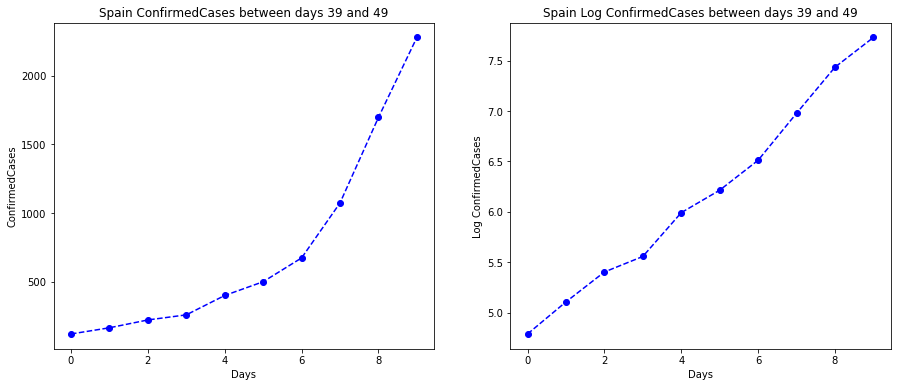

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")


In [21]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

In [23]:
# Select train (real) data from March 1 to last day updated
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
                 '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14']

In [24]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
22472,25580,25581.0,83,156,2020-03-12,2277.0,55.0,-1.0,50,12,...,0.571429,0.964286,2.235294,4.500000,10.000000,46751175.0,94.0,498800.0,45.0,80.0
22473,25581,25582.0,83,156,2020-03-13,5232.0,133.0,-1.0,51,13,...,1.462963,2.800000,3.750000,6.823529,12.300000,46751175.0,94.0,498800.0,45.0,80.0
22474,25582,25583.0,83,156,2020-03-14,6391.0,195.0,-1.0,52,14,...,2.545455,2.611111,4.571429,5.964286,10.470588,46751175.0,94.0,498800.0,45.0,80.0
22475,25583,25584.0,83,156,2020-03-15,7798.0,289.0,-1.0,53,15,...,1.172932,4.254545,4.351852,7.257143,9.321429,46751175.0,94.0,498800.0,45.0,80.0
22476,25584,25585.0,83,156,2020-03-16,9942.0,342.0,-1.0,54,16,...,0.753846,1.571429,5.218182,5.333333,8.771429,46751175.0,94.0,498800.0,45.0,80.0
22477,25585,25586.0,83,156,2020-03-17,11748.0,533.0,-1.0,55,17,...,0.844291,1.733333,3.007519,8.690909,8.870370,46751175.0,94.0,498800.0,45.0,80.0
22478,25586,25587.0,83,156,2020-03-18,13910.0,623.0,-1.0,56,18,...,0.821637,1.155709,2.194872,3.684211,10.327273,46751175.0,94.0,498800.0,45.0,80.0
22479,25587,25588.0,83,156,2020-03-19,17963.0,830.0,-1.0,57,19,...,0.557223,1.426901,1.871972,3.256410,5.240602,46751175.0,94.0,498800.0,45.0,80.0
22480,25588,25589.0,83,156,2020-03-20,20410.0,1043.0,-1.0,58,20,...,0.674157,0.956848,2.049708,2.608997,4.348718,46751175.0,94.0,498800.0,45.0,80.0
22481,25589,25590.0,83,156,2020-03-21,25374.0,1375.0,-1.0,59,21,...,0.656627,1.207063,1.579737,3.020468,3.757785,46751175.0,94.0,498800.0,45.0,80.0


In [47]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    # print(X_train,"-------------------------")
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 69, 112
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

ValueError: x and y must have same first dimension, but have shapes (35,) and (36,)

In [26]:
country_name = "Spain"
march_day = 21
+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 69, 112
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

Country_Region  Province_State  Day_num
22471             156              83       49
22472             156              83       50
22473             156              83       51
22474             156              83       52
22475             156              83       53
22476             156              83       54
22477             156              83       55
22478             156              83       56
22479             156              83       57
22480             156              83       58
22481             156              83       59
22482             156              83       60
22483             156              83       61
22484             156              83       62
22485             156              83       63
22486             156              83       64
22487             156              83       65
22488             156              83       66
22489             156              83       67
22490             156              83       68
22491             15

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [41]:
ts = time.time()

def linreg_basic_all_countries(data, day_start, train_lim, test_lim):
    
    data2 = data.loc[data.Day_num >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    print("Currently running Linear Regression for all countries")

    # Main loop for countries
    for c in data2['Country_Region'].unique():

        # List of provinces
        provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

        # If the country has several Province/State informed
        if len(provinces_list)>1:
            for p in provinces_list:
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

        # No Province/State informed
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

    # Apply exponential transf. and clean potential infinites due to final numerical precision
    data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
    data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
    return data_pred


day_start = 65
#data_pred = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
#get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Process finished in  0.0  seconds


In [27]:
ts = time.time()

# Set the dataframe where we will update the predictions
day_start = 65
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data2[data2.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Linear Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
#data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
#data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Linear Regression for all countries
Process finished in  2.96  seconds


In [28]:
# New split function, for one forecast day
def split_data_one_day(df, d, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train
    x_train = df[df.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = df[df.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

In [44]:
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

ValueError: x and y must have same first dimension, but have shapes (35,) and (36,)